In [1]:
import harmonica as hm
import numpy as np
import verde as vd

from magali._inversion import MagneticMomentBz, MagneticDipoleBz
from magali._synthetic import dipole_bz

from magali._units import (
    meter_to_micrometer,
    coordinates_micrometer_to_meter,
    nanotesla_to_tesla,
    tesla_to_nanotesla,
)

import matplotlib.pyplot as plt

In [2]:
dipole_coordinates = (500, 500, -15)
true_inclination = 30
true_declination = 40
true_intensity = 5e-11

In [3]:
coordinates = vd.grid_coordinates(
    region=[490, 510, 490, 510],
    spacing=1,
    extra_coords=5,
)

true_intensity = 5e-10

true_moment = hm.magnetic_angles_to_vec(
    inclination=true_inclination,
    declination=true_declination,
    intensity=true_intensity,
)

data = dipole_bz(coordinates, dipole_coordinates, true_moment)

model = MagneticDipoleBz((490, 490, -10) + tuple((2, 2.5, -1.5)))

model.fit(coordinates, data)

print("Recovered location:", meter_to_micrometer(model.location_))
print("Recovered moment:", model.dipole_moment_)
print("True location:", dipole_coordinates)
print("True moment:", true_moment)

Recovered location: [-1.09056822e+65 -1.10126858e+65 -7.72632584e+64]
Recovered moment: [7.69164994e+90 7.75157642e+90 3.61687474e+90]
True location: (500, 500, -15)
True moment: (np.float64(2.783351996132097e-10), np.float64(3.317069740844692e-10), np.float64(-2.4999999999999996e-10))


In [4]:
model.misfit

[np.float64(7.376371744083828e+25),
 np.float64(1.1225931274945406e+16),
 np.float64(1.1225931274945406e+16)]

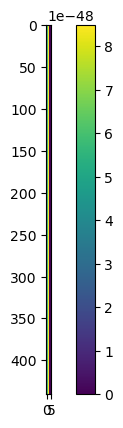

In [6]:
scale = np.max(np.abs(model.jacobian))

plt.imshow(model.jacobian, vmin=-scale, vmax=scale, cmap="RdBu_r")
plt.colorbar()